In [23]:
import numpy as np
from misc import load_fits_data

In [6]:
import tensorflow as tf
from astropy.io import fits
from sklearn.model_selection import train_test_split

In [24]:
# Load data
data_dir = "../augmented_dataset"  # Path to .fits data folder
image_size = (354, 354)  # Resize all images to 128x128
X, y = load_fits_data(data_dir, image_size)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


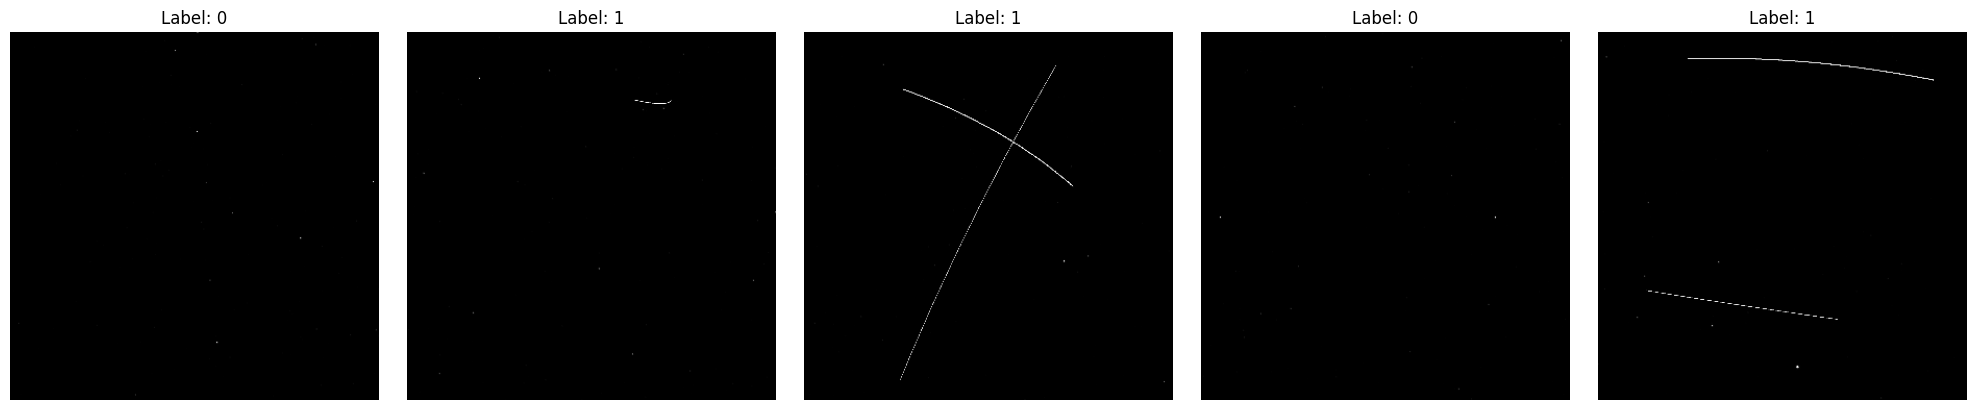

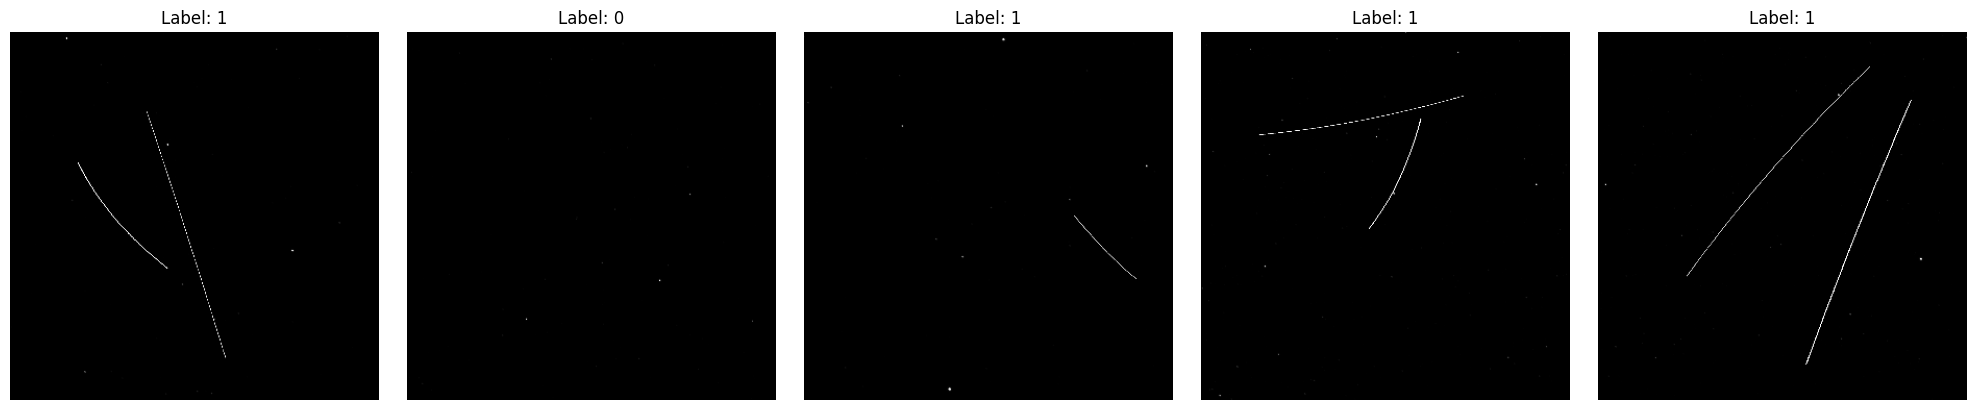

In [25]:
import matplotlib.pyplot as plt
def visualize_data(X, y, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        axes[i].imshow(X[idx], cmap='gray')
        axes[i].set_title(f"Label: {y[idx]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
visualize_data(X_train, y_train)
visualize_data(X_val, y_val)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Define the mean removal filter as a custom Lambda layer
def mean_removal_filter():
    def preprocess(inputs):
        mean = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)  # Compute mean for each image
        return inputs - mean  # Subtract the mean
    return Lambda(preprocess, name='MeanRemoval')

# Define the model for line classification
def create_line_classifier(input_shape):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(6, (5, 5), activation='tanh', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (5, 5), activation='tanh'))
    model.add(MaxPooling2D((2, 2)))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Input shape for grayscale images (e.g., 354x354 pixels)
input_shape = (354, 354, 1)

# Create the model
model = create_line_classifier(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='crossentropy', metrics=['accuracy'])

# Save the best model during training
checkpoint = ModelCheckpoint('line_classifier_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=[checkpoint])


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 310ms/step - accuracy: 0.8617 - loss: 0.2512 - val_accuracy: 0.9508 - val_loss: 0.1355
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.9906 - loss: 0.0359 - val_accuracy: 0.9545 - val_loss: 0.1718
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 302ms/step - accuracy: 0.9770 - loss: 0.0718 - val_accuracy: 0.9489 - val_loss: 0.1997
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.9583 - val_loss: 0.2180
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9356 - val_loss: 0.3011
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accuracy: 0.9802 - loss: 0.0593 - val_accuracy: 0.9754 - val_loss: 0.1125
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.9949 - loss: 0.0219 - val_accuracy: 0.9489 - val_loss: 0.2472
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.9974 - loss: 0.0070 - val_accu

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


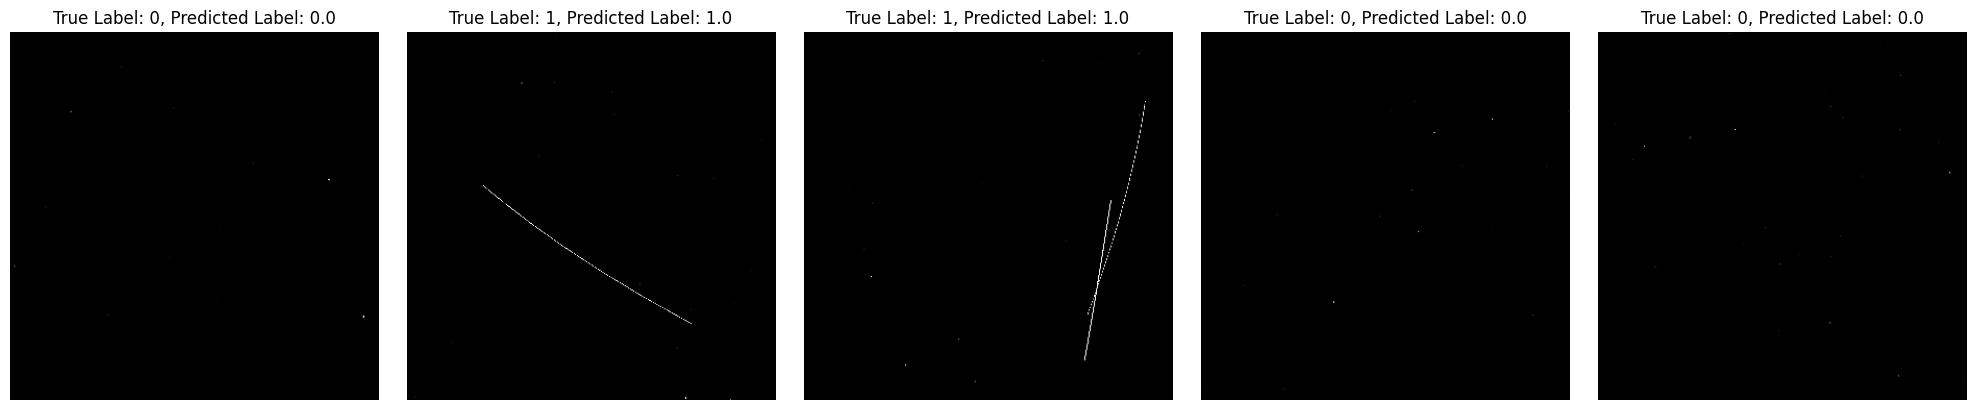

In [30]:
# Test the model on the validation set
predictions = model.predict(X_val)

# Convert predictions to binary labels (0 or 1)
predicted_labels = np.round(predictions).flatten()

# Plot some prediction results
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for i in range(num_samples):
    idx = np.random.randint(0, len(X_val))
    axes[i].imshow(X_val[idx], cmap='gray')
    axes[i].set_title(f"True Label: {y_val[idx]}, Predicted Label: {predicted_labels[idx]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()